In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

### Create Dataloader and Dataset

In [11]:
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = np.random.rand(1,num_curves) #this will be multplied by 1e-5 to get the right scale at the end
    
    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y


def create_dataloader(x, y, batch_size):
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()

    
    torch_dataset = Data.TensorDataset(x, y) 

    dataloader = Data.DataLoader(torch_dataset, batch_size=batch_size, shuffle=True) 
    
    return dataloader

### Define Network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 1000)   
        self.hidden2 = torch.nn.Linear(1000, 200)   
        self.hidden3 = torch.nn.Linear(200, 50)
        self.hidden4 = torch.nn.Linear(50, 300)
        self.hidden5 = torch.nn.Linear(300, 200)
        self.predict = torch.nn.Linear(200, 3)

    def forward(self, x):
        x = F.relu(self.hidden(x))      
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = self.predict(x)            
        return x

net = Net()

### Training Steps

In [13]:
def train(model, x, y, optimiser, criterion):
    model.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimiser.step()
       
    return loss, output

### Run Training

In [15]:
#generate data
num_curves = 10000
x,y = generate_xy(num_curves)
print(x.shape)
print(x.max(), x.min(), x.mean(), x.std())
x_trans = ( (x - x.mean() )/ x.std())
x= x_trans
print(x_trans.max(), x_trans.min(), x_trans.mean(), x_trans.std())



(10000, 150)
589.4828795085618 -0.5419388207959205 79.20287382534497 93.85160071941883
5.437094325207763 -0.8496904904642814 -3.192421142254413e-16 0.9999999999999997


In [23]:

epochs = 100
batch_size = 50
optimiser = optimiser = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-8)

criterion = nn.MSELoss()
loss_plot = np.empty(epochs)

dataloader = create_dataloader(x, y, batch_size)
for epoch in range(epochs):
    print(epoch)
    for i, (train_x, train_y) in enumerate(dataloader):
        loss, predictions = train(net, train_x, train_y, optimiser, criterion)
        
    loss_plot[epoch] = loss.detach().numpy()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.01921347714960575


Text(0, 0.5, 'Loss')

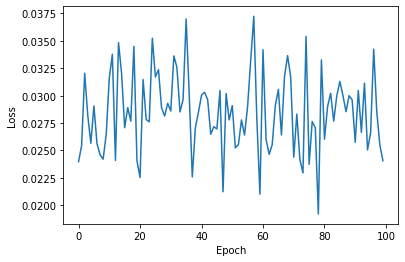

In [24]:
print(loss_plot.min())
plt.plot(loss_plot)
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Testing
##### Tested using the training data (usually use a seperate testing dataset)

In [25]:
def plot_curves(prediction, target, AIF, t):
    print(prediction.detach().numpy())
    predicted_curve = TwoCUM(prediction.detach().numpy(), t, AIF, 0)
    target_curve = TwoCUM(target.detach().numpy(), t, AIF, 0)
    
    plt.plot(t, predicted_curve, label = 'Prediction')
    plt.plot(t, target_curve, label = 'Target')
    plt.legend()
    plt.show()

[0.29660475 0.8403034  0.51255405]


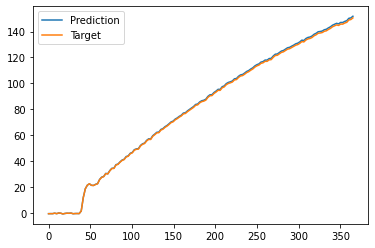

tensor([0.2966, 0.8403, 0.5126], grad_fn=<AddBackward0>) tensor([0.2990, 0.8263, 0.8753])


In [44]:
AIF = np.load("data/AIF.npy")
t = np.arange(0,366,2.45)

#unseen data
# x,y = generate_xy(10)
# x = torch.from_numpy(x).float()
# y = torch.from_numpy(y).float()

for i, (train_x, train_y) in enumerate(dataloader):
    j = np.random.randint(0 ,train_x.shape[0])
    prediction = net(train_x[j])
    plot_curves(prediction, train_y[j], AIF, t)
    print(prediction, train_y[j])
        
    break

### Results log


In [ ]:
epochs = 100
batch_size = 50
nn.MSELoss()

0.0202, lr=0.001, betas=(0.9, 0.999), eps=1e-8
